# Neural & Behavioral Modeling - Week 5 (Exercises)
by Cheng-Kuang, Wu (r10922186@ntu.edu.tw)

In [134]:
%config IPCompleter.greedy=True 
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import *
from torch.distributions.categorical import Categorical

## 1 Drifit Diffusion Model (4+4 points)

Use whatever analytical methods to check if Tren's super EZ implementation(s) of the drift diffusion model produce exGaussian data, especially the exponential long tail. Remember to play around with different model parameters to see how they affect simulation results.

Hints:

[1] For parameter estimation of the ex-Gaussian distribution, you can use scipy.stats.exponnorm.fit().

[2a] You can compare two distributions by Q-Q plots or the Kolmogorov–Smirnov test

[2b] Alternatively, you can compare AIC/BIC to answer whether Exponential, Gaussian, or ex-Gaussian best fits Tren's data.

<font color="red">Please carry out the same analysis for both types of diffusion (4 points each)!</font>

In [ ]:
# Tren's implementation

from numpy import *

mu,sigma=0.2,2 # Diffusion type1
p=0.4 # Diffusion type2
Yend=20 # Threshold for response
Ntrial=1000

RTs=zeros(Ntrial)
for i in range(Ntrial):
    Y=0 # initial drift position
    Ys=[] # drift history
    RT=0 # Reset watch
    while(Y<Yend):
        dY=mu+random.normal(mu,sigma); # type1
        #dY=float((random.rand(1)-p)>0); # type2
        Y=Y+dY
        Ys.append(Y); # Diffusion history in each trial
        RT=RT+1 # clock is running
    RTs[i]=RT;
subplot(1,2,1);plot(Ys) # plot only the last trial to see the diffusion process
subplot(1,2,2);hist(RTs);

In [1]:
### Write your analysis or codes here

## 2 Replicate exisiting findings/models (4+4 points)

Based on your personal interest, please choose and replicate ONE of the following studies. You can replicate 2 core figures/tables <font color="red">(4points each)</font> instead of everything in the paper.

### 2.1 Embodied Cognition

2.1.1 Thelen, E., Schöner, G., Scheier, C., & Smith, L. B. (2001). The dynamics of embodiment: A field theory of infant perseverative reaching. Behavioral and Brain Sciences, 24(1), 1-86.


### 2.2 Instructed Learning

2.2.1 Biele, G., Rieskamp, J., & Gonzalez, R. (2009). Computational models for the combination of advice and individual learning. Cognitive Science, 33(2), 206-242.

2.2.2 Doll, B. B., Jacobs, W. J., Sanfey, A. G., & Frank, M. J. (2009). Instructional control of reinforcement learning: A behavioral and neurocomputational investigation. Brain Research, 1299, 74–94.

2.2.3 Li, J., Delgado, M. R., & Phelps, E. A. (2011). How instructed knowledge modulates the neural systems of reward learning. Proceedings of the National Academy of Sciences, U.S.A., 108, 55–60. (Their <a href=http://www.pnas.org/lookup/suppl/doi:10.1073/pnas.1014938108/-/DCSupplemental/sapp.pdf>supplementary document</a> contains more details about their model.)

### * I choose to reproduce 2.2.1 (5 Sub-figures for 5 different proposed models in Fig. 4)

In [304]:
# Configuration
n_trials = 100

bad_deck_total_payoff = -1250
good_deck_total_payoff = 1250
bad_deck_reward = 50
good_deck_reward = 25
low_var_n_losses = 20
high_var_n_losses = 10

# Advices to choose which deck
n_adva = 1
n_advb = 1
n_advc = 9
n_advd = 19

rec_card_ids = [0] * n_adva + [1] * n_advb + [2] * n_advc + [3] * n_advd

In [431]:
### Write your analysis or codes here
import random

class Deck(object):

    def __init__(self, n_trials: int, n_losses: int, total_payoff: float, reward: float):
        self.n_trials = n_trials
        self.n_losses = n_losses
        self.n_rewards = n_trials - n_losses

        self.total_payoff = total_payoff
        self.reward = reward
        self.loss = -((n_trials * reward - total_payoff - n_losses * reward) / n_losses)

        self.cards = []
        for _ in range(int(n_trials / 10)):
            n_r = int(10 * self.n_rewards / n_trials)
            n_l = int(10 * self.n_losses / n_trials)
            card_10 = [1] * n_r + [0] * n_l
            random.shuffle(card_10)
            self.cards += card_10

        self.card_id = 0 # current card at the top of the deck
        
    def draw(self):
        res = self.cards[self.card_id]
        payoff = self.reward if res else self.loss
        self.card_id += 1
        return res, payoff / 100 # 0 for loss / 1 for reward # in euros instead of eurocent

    def reset_id(self):
        self.card_id = 0

    def calc_total_payoff(self):
        self.reset_id()
        # draw all cards
        total_payoff = 0
        for _ in range(self.n_trials):
            res, payoff = self.draw()
            total_payoff += payoff

        # reset_id
        self.reset_id()
        return total_payoff

class LearningModel(object):

    def __init__(self):
        self.n_options = 4
        self.propensities = [0] * self.n_options
        self.rec_option = None
        self.decay = None
        self.sensitivity = None

    def update(self, choice: int, payoff: float):
        for i in range(len(self.propensities)):
            if i == choice:
                self.propensities[i] = (1 - self.decay) * self.propensities[i] + payoff
            else:
                self.propensities[i] = (1 - self.decay) * self.propensities[i]
    
    # sample a choice from the probability distribution
    def choose(self):
        logits = np.exp(self.sensitivity * np.array(self.propensities))
        probs = logits / logits.sum()
        dist = Categorical(probs=torch.tensor(probs))
        choice = dist.sample().item()
        return choice

class RLModel(LearningModel):

    def __init__(self, rec_option: int, decay: float, sensitivity: float):
        super().__init__()
        self.rec_option = rec_option
        self.decay = decay
        self.sensitivity = sensitivity

class ARCInitial(LearningModel):

    def __init__(self, rec_option: int, decay: float, sensitivity: float, init: float):
        super().__init__()
        self.rec_option = rec_option
        self.decay = decay
        self.sensitivity = sensitivity
        self.init = init

        self.set_propensity(choice=rec_option, best_payoff=abs(good_deck_total_payoff / (100 * 100)) * self.init) # 100 times and 100 eurocent per euro
    
    # set more initial propensity for the recommended deck
    def set_propensity(self, choice: int, best_payoff: float):
        self.propensities[choice] = best_payoff

class ARCOutcomeBonus(LearningModel):

    def __init__(self, rec_option: int, decay: float, sensitivity: float, rho: float):
        super().__init__()
        self.rec_option = rec_option
        self.decay = decay
        self.sensitivity = sensitivity
        self.rho = rho

    # overwrite the update method
    def update(self, choice: int, payoff: float):
        for i in range(len(self.propensities)):
            if i == choice:
                self.propensities[i] = (1 - self.decay) * self.propensities[i] + payoff
                # add extra propensity if it is the recommended deck
                if i == self.rec_option:
                    self.propensities[i] += abs(good_deck_total_payoff / (100 * 100)) * self.rho
            else:
                self.propensities[i] = (1 - self.decay) * self.propensities[i]

class ARCDecay(LearningModel):

    def __init__(self, rec_option: int, decay: float, sensitivity: float, decay_advice: float):
        assert decay_advice < decay # check that the propensity for the adviced deck decays less

        super().__init__()
        self.rec_option = rec_option
        self.decay = decay
        self.sensitivity = sensitivity
        self.decay_advice = decay_advice

    # overwrite the update method
    def update(self, choice: int, payoff: float):
        for i in range(len(self.propensities)):
            decay = self.decay_advice if (i == self.rec_option) else self.decay # the past propensity decays less for the recommended deck
            if i == choice:
                self.propensities[i] = (1 - decay) * self.propensities[i] + payoff
            else:
                self.propensities[i] = (1 - decay) * self.propensities[i]

class ARCCertainty(LearningModel):

    def __init__(self, rec_option: int, decay: float, sensitivity: float, tau: float):
        super().__init__()
        self.rec_option = rec_option
        self.decay = decay
        self.sensitivity = sensitivity
        self.tau = tau

    # overwrite the choose method
    def choose(self):
        logits = np.exp(self.sensitivity * np.array(self.propensities))
        probs = logits / logits.sum()

        # if not certain enough, choose the recommended deck
        if np.std(probs) < self.tau:
            return self.rec_option

        # else choose according to the agent's own propensity
        else:
            dist = Categorical(probs=torch.tensor(probs))
            choice = dist.sample().item()
            return choice

In [380]:
# Utility functions
def make_new_decks():
    deck_a = Deck(n_trials=n_trials, n_losses=low_var_n_losses, total_payoff=bad_deck_total_payoff, reward=bad_deck_reward) # bad deck, low variance
    deck_b = Deck(n_trials=n_trials, n_losses=high_var_n_losses, total_payoff=bad_deck_total_payoff, reward=bad_deck_reward) # bad deck, high variance
    deck_c = Deck(n_trials=n_trials, n_losses=low_var_n_losses, total_payoff=good_deck_total_payoff, reward=good_deck_reward) # good deck, low variance
    deck_d = Deck(n_trials=n_trials, n_losses=high_var_n_losses, total_payoff=good_deck_total_payoff, reward=good_deck_reward) # good deck, low variance
    return [deck_a, deck_b, deck_c, deck_d]

def simulate_models(models):
    choices_l = [[] for _ in range(len(models))]
    for i, model in enumerate(models):
        decks = make_new_decks()
        choices = choices_l[i]
        # learning
        # must choose the recommended option at the first step
        choice = model.rec_option
        choices.append(choice)
        res, payoff = decks[choice].draw()
        model.update(choice, payoff)
        # the remaining steps
        for _ in range(n_trials - 1):
            choice = model.choose()
            choices.append(choice)
            res, payoff = decks[choice].draw()
            model.update(choice, payoff)

    return np.array(choices_l)

def calc_block_props(choices_l):
    n_blocks = 10
    n_per_block = int(n_trials / n_blocks)

    block_props = [[] for _ in range(4)] # 4 decks
    for i in range(4):
        for block in range(n_blocks):
            all_choices = choices_l[:, block: block + n_per_block].flatten()
            prop = (all_choices == i).sum() / len(all_choices)
            block_props[i].append(prop)
    
    return block_props

def plot_props(block_props):
    plt.plot(block_props[0], label="Bad deck, low var")
    plt.plot(block_props[1], label="Bad deck, high var")
    plt.plot(block_props[2], label="Good deck, low var")
    plt.plot(block_props[3], label="Good deck, high var")
    plt.legend(loc="upper left");

## RL Model

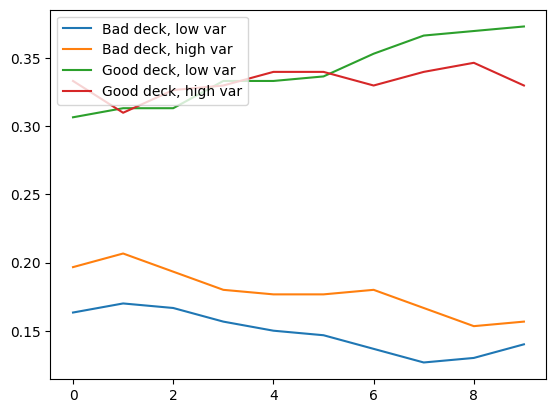

In [303]:
rl_models = [RLModel(rec_option=rec_card_id, decay=0.16, sensitivity=3.26) for rec_card_id in rec_card_ids] # use the mean model parameter values from the paper

choices_l = simulate_models(rl_models)
block_props = calc_block_props(choices_l)
plot_props(block_props)

## ARC-Initial Model
We can observe higher initial proportion of the "Good deck, high var" deck than the one in vanilla RL model, since the initial propensity of the recommended deck is higher

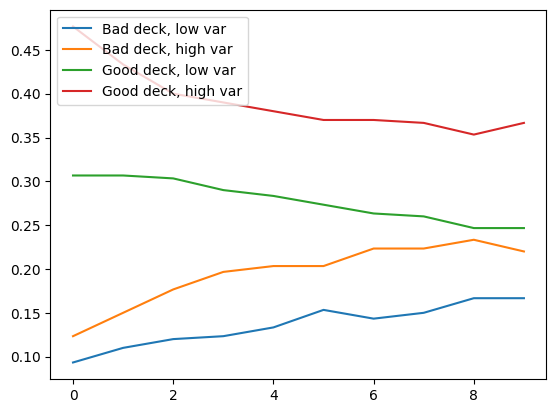

In [315]:
arc_init_models = [ARCInitial(rec_option=rec_card_id, decay=0.18, sensitivity=1.55, init=21.18) for rec_card_id in rec_card_ids]

choices_l = simulate_models(arc_init_models)
block_props = calc_block_props(choices_l)
plot_props(block_props)

## ARC-Outcome-Bonus Model
This figure is reproduced relatively like the one in the paper.

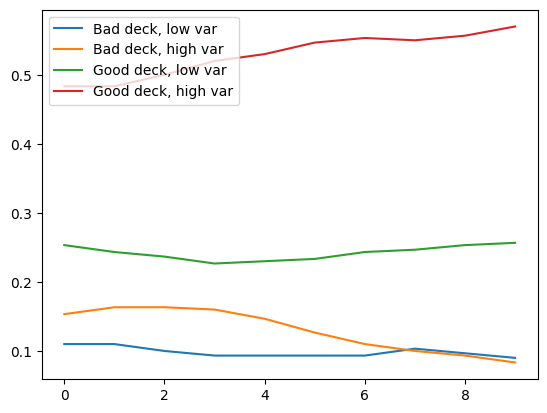

In [327]:
arc_outcomebonus_models = [ARCOutcomeBonus(rec_option=rec_card_id, decay=0.36, sensitivity=3.1, rho=3.89) for rec_card_id in rec_card_ids]

choices_l = simulate_models(arc_outcomebonus_models)
block_props = calc_block_props(choices_l)
plot_props(block_props)

## ARC-Decay Model

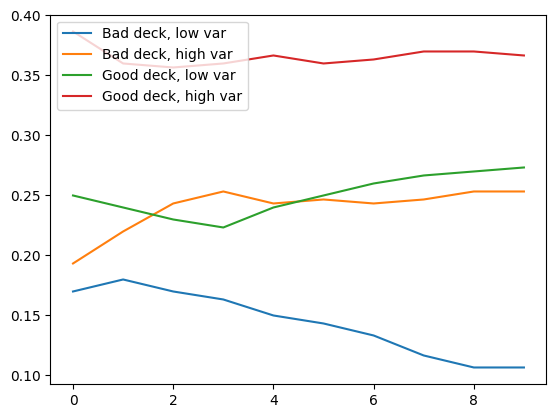

In [429]:
arc_decay_models = [ARCDecay(rec_option=rec_card_id, decay=0.20, sensitivity=3.09, decay_advice=0.10) for rec_card_id in rec_card_ids]

choices_l = simulate_models(arc_decay_models)
block_props = calc_block_props(choices_l)
plot_props(block_props)

## ARC-Certainty Model

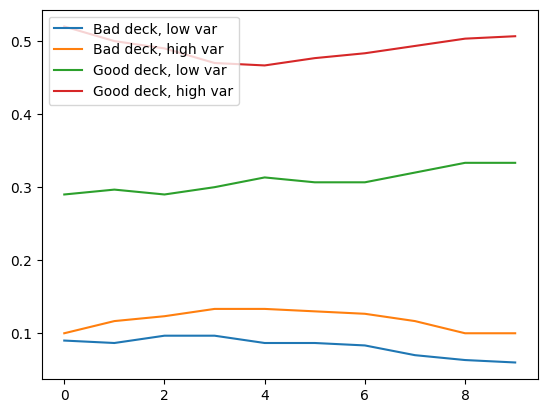

In [434]:
arc_certainty_models = [ARCCertainty(rec_option=rec_card_id, decay=0.32, sensitivity=2.44, tau=0.16) for rec_card_id in rec_card_ids]

choices_l = simulate_models(arc_certainty_models)
block_props = calc_block_props(choices_l)
plot_props(block_props)

## Conclusion
Cannot reproduce the figures in the paper quite exactly (although the trend is still similar). I think part of the reason is that there is no original partcipants' data to fit the model parameters for each individual participant, so I use the mean values for those parameters instead.